<a href="https://colab.research.google.com/github/lastinm/Deep-neural-networks-on-Python/blob/main/UrFU_Deep_neural_networks_on_Python_Testing_on_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#УрФУ. Глубокие нейронные сети на Python. Cоревнование на Kaggle


## Загрузка пакетов и модулей

In [1]:
!pip install kaggle
!pip install -q opendatasets
!pip install pytorch-lightning
!pip install pytorch-ignite
!pip install onnx
!pip install keract

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.2/802.2 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 34.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-many

In [2]:
!cat /etc/*release*

DISTRIB_ID=Ubuntu
DISTRIB_RELEASE=22.04
DISTRIB_CODENAME=jammy
DISTRIB_DESCRIPTION="Ubuntu 22.04.3 LTS"
PRETTY_NAME="Ubuntu 22.04.3 LTS"
NAME="Ubuntu"
VERSION_ID="22.04"
VERSION="22.04.3 LTS (Jammy Jellyfish)"
VERSION_CODENAME=jammy
ID=ubuntu
ID_LIKE=debian
HOME_URL="https://www.ubuntu.com/"
SUPPORT_URL="https://help.ubuntu.com/"
BUG_REPORT_URL="https://bugs.launchpad.net/ubuntu/"
PRIVACY_POLICY_URL="https://www.ubuntu.com/legal/terms-and-policies/privacy-policy"
UBUNTU_CODENAME=jammy


In [3]:
!nvidia-smi
!nvcc --version

Wed May 15 18:31:18 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Импорт модулей

In [4]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras import activations
from keract import get_activations, display_activations

import numpy as np
import pandas as pd

from torchvision.transforms import Compose, Normalize, ToTensor

from tqdm import tqdm  # Библиотека для отрисовки progress bar.

from ignite.engine import Events, create_supervised_evaluator, create_supervised_trainer
     # Events - перечисление различных событий из жизненного цикла модели.
     # create_supervised_evaluator - валидатор для обучения с учителем.
     # create_supervised_trainer  - тренер для обучения с учителем.
from ignite.metrics import Accuracy, Loss
     # Это просто удобный логгер, которым можно пользоваться, а можно и не пользоваться.

from tensorflow.keras.layers import BatchNormalization

from google.colab import files

import opendatasets as od

## Загружаем DataSet с Kaggle соревнование DL-URFU-2024

In [7]:
uploaded = files.upload() #просто запускаем и выбираем файл  API токена в проводнике

#↓ строка которая активирует наш API токен
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [9]:
od.download("https://www.kaggle.com/competitions/copy-of-dl-urfu-2024/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: maximlastin
Your Kaggle Key: ··········


100%|██████████| 68.8M/68.8M [00:01<00:00, 71.1MB/s]



Extracting archive ./copy-of-dl-urfu-2024/copy-of-dl-urfu-2024.zip to ./copy-of-dl-urfu-2024


## Подготавливаем данные

In [11]:
input_train = pd.read_csv('/content/copy-of-dl-urfu-2024/fashion-mnist_train.csv')
input_test = pd.read_csv('/content/copy-of-dl-urfu-2024/fashion-mnist_test.csv')
submission = pd.read_csv('/content/copy-of-dl-urfu-2024/sample_submission.csv')

Размерности тренировочных и тестовых данных

In [12]:
input_train.shape

(60000, 785)

In [13]:
input_test.shape

(10000, 785)

In [14]:
# Извлечение пиксельных данных, исключая 'label' и 'id'
X_train = input_train.drop(['label'], axis=1).values
X_test = input_test.drop(['label'], axis=1).values

# Получение меток
y_train = input_train['label'].values
y_test = input_test['label'].values

In [10]:
# Различные константы
IMG_WIDTH, IMG_HEIGHT = 28, 28
BATCH_SIZE = 250
EPOCHS = 8
NUM_CLASSES = 10
VALIDATION_SPLIT = 0.2
VERBOSITY = 1

In [16]:
# Подготавливаем данные.
input_train = X_train.reshape(input_train.shape[0], IMG_WIDTH, IMG_HEIGHT, 1)
input_test = X_test.reshape(input_test.shape[0], IMG_WIDTH, IMG_HEIGHT, 1)
input_shape = (IMG_WIDTH, IMG_HEIGHT, 1)

# Нормализуем данные (0-255 -> 0-1.0).
# В Python 3 операнды всегда приводятся к числам с плавающей точкой. Для целочисленного деления введён отдельный оператор // .

input_train = input_train / 255
input_test = input_test / 255

target_train = tensorflow.keras.utils.to_categorical(y_train, NUM_CLASSES)
target_test = tensorflow.keras.utils.to_categorical(y_test, NUM_CLASSES)

In [17]:
input_train.shape

(60000, 28, 28, 1)

## Создаём модель

In [18]:
model = Sequential()
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=input_shape, padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(NUM_CLASSES, activation='softmax'))

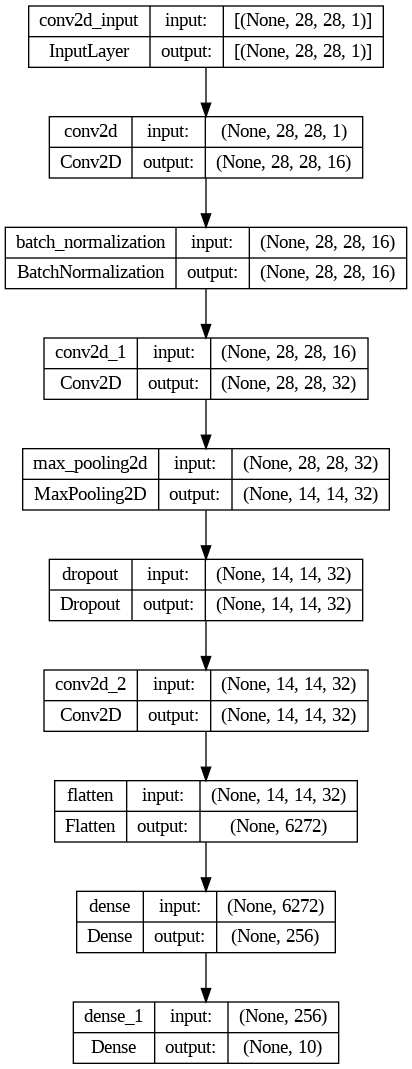

In [19]:
# Визуализируем модель.
plot_model(model, show_shapes = True)

In [20]:
# Обучаем модель
model.compile(
    loss=tensorflow.keras.losses.categorical_crossentropy,
    optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

model.fit(
    input_train,
    target_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=VERBOSITY,
    validation_split=VALIDATION_SPLIT
)

# Сохраняем модель
model.save("cnn_mnist_classification")

Epoch 1/8
192/192 [==============================] - 9s 14ms/step - loss: 0.4871 - accuracy: 0.8319 - val_loss: 1.4458 - val_accuracy: 0.8902
Epoch 2/8
192/192 [==============================] - 2s 12ms/step - loss: 0.2763 - accuracy: 0.8990 - val_loss: 0.6748 - val_accuracy: 0.8999
Epoch 3/8
192/192 [==============================] - 2s 12ms/step - loss: 0.2309 - accuracy: 0.9141 - val_loss: 0.2753 - val_accuracy: 0.9062
Epoch 4/8
192/192 [==============================] - 3s 13ms/step - loss: 0.1961 - accuracy: 0.9278 - val_loss: 0.2226 - val_accuracy: 0.9222
Epoch 5/8
192/192 [==============================] - 3s 14ms/step - loss: 0.1717 - accuracy: 0.9363 - val_loss: 0.2376 - val_accuracy: 0.9122
Epoch 6/8
192/192 [==============================] - 2s 12ms/step - loss: 0.1458 - accuracy: 0.9461 - val_loss: 0.2252 - val_accuracy: 0.9226
Epoch 7/8
192/192 [==============================] - 2s 12ms/step - loss: 0.1278 - accuracy: 0.9525 - val_loss: 0.2233 - val_accuracy: 0.9218
Epoch 

In [21]:
predictions = model.predict(input_test)
predicted_classes = predictions.argmax(axis=1)

313/313 [==============================] - 1s 3ms/step


In [23]:
# Сохранение предсказанных меток в колонке 'Category'
submission['Category'] = predicted_classes

# Сохранение результатов в CSV
submission.to_csv('/content/final_submission.csv', index=False)

In [24]:
!kaggle competitions submit -c copy-of-dl-urfu-2024 -f final_submission.csv -m "lastin maksim a."

100% 67.3k/67.3k [00:00<00:00, 103kB/s]
Successfully submitted to [DL-URFU-2024] Построение классифика...

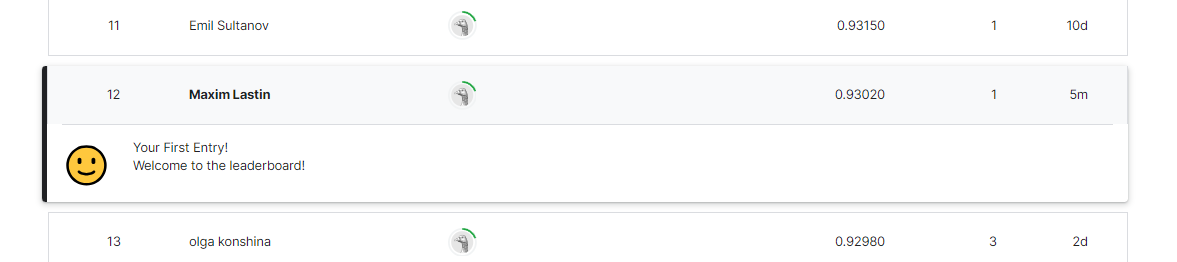